In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from scipy.stats import bootstrap
import json
import mdtraj as md

In [2]:
prior_ratios = '000 010 020 030 040 050 060 070 075 080 085 090 095 100'.split()

In [3]:
RMSE_vs_prior_vs_jcouplingtype = {'af2chi_HA_CA_CB_HB':[], 'af2chi_C_CA_CB_CG':[], 'af2chi_N_CA_CB_CG':[], 'af2chi_HA_CA_CB_HB_err':[], 'af2chi_C_CA_CB_CG_err':[], 'af2chi_N_CA_CB_CG_err':[], 'af2chi_prior_HA_CA_CB_HB':[], 'af2chi_prior_C_CA_CB_CG':[], 'af2chi_prior_N_CA_CB_CG':[], 'af2chi_prior_HA_CA_CB_HB_err':[], 'af2chi_prior_C_CA_CB_CG_err':[], 'af2chi_prior_N_CA_CB_CG_err':[]}

In [4]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

def load_json(file):
    with open(file, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

In [5]:
def karplus(karplus_coeffs, phi):
    A, B, C, delta = karplus_coeffs
    j3 = A*np.cos(phi+delta)*np.cos(phi+delta) + B*np.cos(phi+delta) + C
    return j3

In [6]:
#Val, Ile, Thr (C and N) from https://pubs.acs.org/doi/10.1021/ja029972s
#Rest from https://pubs.acs.org/doi/10.1021/ja003724j
karplus_coeffs_dict =  {'VAL_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'ILE_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'THR_C': [2.76, -0.67, 0.19, np.deg2rad(17)],
                        
                        'ASN_C': [2.31, -0.87, 1.37, 0],
                        'ASP_C': [2.31, -0.87, 1.06, 0],
                        'HIS_C': [2.31, -0.87, 0.98, 0],
                        'MET_C': [2.31, -0.87, 0.61, 0],
                        'ARG_C': [2.31, -0.87, 0.57, 0],
                        'GLU_C': [2.31, -0.87, 0.57, 0],
                        'GLN_C': [2.31, -0.87, 0.57, 0],
                        'LYS_C': [2.31, -0.87, 0.57, 0],
                        'PRO_C': [2.31, -0.87, 0.57, 0],
                        'LEU_C': [2.31, -0.87, 0.53, 0],
                        'PHE_C': [2.31, -0.87, 0.49, 0],
                        'TRP_C': [2.31, -0.87, 0.49, 0],
                        'TYR_C': [2.31, -0.87, 0.49, 0],
                        
                        'VAL_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'ILE_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'THR_N': [2.01, 0.21, -0.12, np.deg2rad(7)],
                        
                        'ASN_N': [1.29, -0.49, 0.89, 0],
                        'ASP_N': [1.29, -0.49, 0.70, 0],
                        'HIS_N': [1.29, -0.49, 0.65, 0],
                        'MET_N': [1.29, -0.49, 0.41, 0],
                        'ARG_N': [1.29, -0.49, 0.39, 0],
                        'GLN_N': [1.29, -0.49, 0.39, 0],
                        'GLU_N': [1.29, -0.49, 0.39, 0],
                        'LYS_N': [1.29, -0.49, 0.39, 0],
                        'LEU_N': [1.29, -0.49, 0.36, 0],
                        'PRO_N': [1.29, -0.49, 0.36, 0],
                        'PHE_N': [1.29, -0.49, 0.34, 0],
                        'TRP_N': [1.29, -0.49, 0.34, 0],
                        'TYR_N': [1.29, -0.49, 0.34, 0],
                        
                        'ALA_HAHB': [7.23, -1.37, 3.01, 0],
                        'ARG_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASN_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASP_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLN_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLU_HAHB': [7.23, -1.37, 2.40, 0],
                        'HIS_HAHB': [7.23, -1.37, 2.40, 0],
                        'LEU_HAHB': [7.23, -1.37, 2.40, 0],
                        'LYS_HAHB': [7.23, -1.37, 2.40, 0],
                        'MET_HAHB': [7.23, -1.37, 2.40, 0],
                        'PHE_HAHB': [7.23, -1.37, 2.40, 0],
                        'PRO_HAHB': [7.23, -1.37, 2.40, 0],
                        'TRP_HAHB': [7.23, -1.37, 2.40, 0],
                        'TYR_HAHB': [7.23, -1.37, 2.40, 0],
                        'ILE_HAHB': [7.23, -1.37, 1.79, 0],
                        'VAL_HAHB': [7.23, -1.37, 1.79, 0],
                        'CYS_HAHB': [7.23, -1.37, 1.71, 0],
                        'SER_HAHB': [7.23, -1.37, 1.42, 0],
                        'THR_HAHB': [7.23, -1.37, 0.81, 0],

                        'ALA_CHB': [4.02, -1.58, 1.71, 0],
                        'ARG_CHB': [4.02, -1.58, 1.41, 0],
                        'ASN_CHB': [4.02, -1.58, 1.41, 0],
                        'ASP_CHB': [4.02, -1.58, 1.41, 0],
                        'GLN_CHB': [4.02, -1.58, 1.41, 0],
                        'GLU_CHB': [4.02, -1.58, 1.41, 0],
                        'HIS_CHB': [4.02, -1.58, 1.41, 0],
                        'LEU_CHB': [4.02, -1.58, 1.41, 0],
                        'LYS_CHB': [4.02, -1.58, 1.41, 0],
                        'MET_CHB': [4.02, -1.58, 1.41, 0],
                        'PHE_CHB': [4.02, -1.58, 1.41, 0],
                        'PRO_CHB': [4.02, -1.58, 1.41, 0],
                        'TRP_CHB': [4.02, -1.58, 1.41, 0],
                        'TYR_CHB': [4.02, -1.58, 1.41, 0],
                        'ILE_CHB': [4.02, -1.58, 1.10, 0],
                        'VAL_CHB': [4.02, -1.58, 1.10, 0],
                        'CYS_CHB': [4.02, -1.58, 1.06, 0],
                        'SER_CHB': [4.02, -1.58, 0.91, 0],
                        'THR_CHB': [4.02, -1.58, 0.61, 0],
                                  }

In [7]:
def calc_C_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name C')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'CG' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name CG')[0]

    elif 'CG1' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG1')[0]

    elif 'CG2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG2')[0]
    else:
        raise Exception('No correct CG found')

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)

    return j3_calc_avg


In [8]:
def calc_N_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    print(list(res_slice.topology.atoms))

    index_1 = res_slice.top.select('name N')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1]
    split_atom_names = [split_atom_names[0], split_atom_names[1:]]

    print(split_atom_names)

    if 'CG' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name CG')[0]

    elif 'CG1' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG1')[0]

    elif 'CG2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG2')[0]
    else:
        raise Exception('No correct CG found')

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    print(atom_idxs)
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()
    print(angles)

    j3_calc = karplus(karplus_coeffs, angles)
    print(j3_calc.shape)
    print(j3_calc)

    j3_calc_avg = np.average(j3_calc)

    print(j3_calc_avg)

    return j3_calc_avg


In [9]:
def calc_HA_CA_CB_HB_jcoupling_OLD(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]

    elif '1HB' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB2')[0]

    elif '2HB' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB3')[0]

    else:
        raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [10]:
def calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]
    else:
        try: 
            res_slice.top.select('name HB3')[0]
            print('There is an HB3, so assuming HB2 HB3 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB3')[0]
            else:
                raise Exception('No correct HB found')
        except:
            print('There is no HB3, so assuming HB1 HB2 naming')
            if '1HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB1')[0]
            else:
                raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [11]:
def get_atoms_lines(exp_j3_df, resnum):
    #Get rows of experimental data with resid
    row = exp_j3_df[exp_j3_df['resid'] == resnum]
    
    #Get the label with atoms (there can be multiple lines for one resid if there are multiple CG)
    atoms_lines = row['label'].values

    return atoms_lines

In [12]:
def make_plot_arrays_dict(j3_results_dict, exp_j3_df):

    j3_results_arrs = {}
    for ensemble_type in j3_results_dict.keys():
        ensemble_j3s = j3_results_dict[ensemble_type]

        ensemble_j3_arr = []
        for resnum, atoms_line in zip(exp_j3_df['resid'], exp_j3_df['label']):
            print(ensemble_type)
            print(resnum, atoms_line)
            ensemble_j3_arr.append(ensemble_j3s[f'{resnum}_{atoms_line}'])
        j3_results_arrs[ensemble_type] = np.array(ensemble_j3_arr)

    return j3_results_arrs


In [13]:
def make_plot(j3_exp_arr_C, j3_exp_arr_N, j3_exp_arr_HAHB, j3_ensemble_arr_C, j3_ensemble_arr_N, j3_ensemble_arr_HAHB, title, outfile):

    pltmax = np.amax([ *j3_exp_arr_C, *j3_exp_arr_N, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_N, *j3_ensemble_arr_HAHB])
    pltmax += 0.1*pltmax
    pltmin = np.amin([*j3_exp_arr_C, *j3_exp_arr_N, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_N, *j3_ensemble_arr_HAHB])
    pltmin -= 0.1*pltmax
    
    RMSE_C = root_mean_squared_error(j3_exp_arr_C, j3_ensemble_arr_C)
    RMSE_N = root_mean_squared_error(j3_exp_arr_N, j3_ensemble_arr_N)
    RMSE_HAHB = root_mean_squared_error(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB)
    
    #Plotting
    fig = plt.figure(figsize=(4,4))

    plt.title(title, fontsize=15)
    
    plt.plot([-100,100], [-100,100], '--', color='black')

    plt.plot(j3_exp_arr_C, j3_ensemble_arr_C, 'o', c='black', markeredgecolor='black', label='C\'-Cα-Cβ-Cγ') #(RMSE={RMSE_C:.2})')
    plt.plot(j3_exp_arr_N, j3_ensemble_arr_N, 'o', c='ghostwhite', markeredgecolor='black', label='N-Cα-Cβ-Cγ') #(RMSE={RMSE_N:.2})')
    plt.plot(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB, 'o', c='gray', markeredgecolor='black', label='Hα-Cα-Cβ-Hβ') #(RMSE={RMSE_HAHB:.2})')
    
    plt.xlabel('$^3J$ experiment (Hz)', fontsize=15)
    plt.ylabel('$^3J$ model (Hz)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.xlim(pltmin, pltmax)
    plt.ylim(pltmin, pltmax)
    
    plt.legend(fontsize=15, bbox_to_anchor=(1,1.3), ncol=3)
    
    plt.savefig(outfile, bbox_inches='tight')

In [14]:
exp_j3_N_CA_CB_CG = pd.read_csv('../../data/jcouplings_expt/UBQ_expt/NC_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_N_CA_CB_CG = exp_j3_N_CA_CB_CG[exp_j3_N_CA_CB_CG['label'].str.contains("N")]

exp_j3_C_CA_CB_CG = pd.read_csv('../../data/jcouplings_expt/UBQ_expt/C_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_HA_CA_CB_HB = pd.read_csv('../../data/jcouplings_expt/UBQ_expt/HA_CA_CB_HB_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])


/tmp/ipykernel_211323/3632437955.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_N_CA_CB_CG = pd.read_csv('../../data/jcouplings_expt/UBQ_expt/NC_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_211323/3632437955.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_C_CA_CB_CG = pd.read_csv('../../data/jcouplings_expt/UBQ_expt/C_CA_CB_CG_scalar_couplings.dat', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_211323/3632437955.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_HA_CA_CB_HB = pd.read_csv('../../data/jcouplings_expt/UBQ

In [15]:
for prior_ratio in prior_ratios:

    sidechain_ensemble_dir = f'../../data/af2chi_data/af2chi_runs_UBQ_priorscan/ubq_rew_{prior_ratio}/sidechain_ensemble_withH'
    for frame_idx in range(100):
        print(frame_idx)
        frame = md.load(f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb')
        frame.time = frame_idx
        if frame_idx==0:
            ensemble_af2chi=frame 
        else:
            ensemble_af2chi = ensemble_af2chi.join(frame)

    sidechain_ensemble_dir_norew = f'../../data/af2chi_data/af2chi_runs_UBQ_priorscan/ubq_norew_{prior_ratio}/sidechain_ensemble_withH'

    for frame_idx in range(100):
        print(frame_idx)
        frame = md.load(f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb')
        frame.time = frame_idx
        if frame_idx==0:
            ensemble_af2chi_prior=frame 
        else:
            ensemble_af2chi_prior = ensemble_af2chi_prior.join(frame)

    ensembles = {}

    ensembles['af2chi'] = ensemble_af2chi
    ensembles['af2chi_prior'] = ensemble_af2chi_prior

    j3_results = {}
    #j3_results_reversedassignment = {}

    for ensemble_type in ensembles.keys():
        
        traj = ensembles[ensemble_type]
        
        j3_vs_dihedraltype = {}
        #j3_vs_dihedraltype_reversedassignment = {}

        for residue in ensembles[ensemble_type].top.residues:
            residue = str(residue)
            #restype=residue[:3]
            #resnum=i+1 #int(residue[3:])

            resnum = int(''.join(filter(lambda x: x.isdigit(), residue)))
            restype = str(''.join(filter(lambda x: x.isalpha(), residue)))

            print(resnum)
            print(restype)
    
            C_karplus_params_available = True
            H_karplus_params_available = True
            N_karplus_params_available = True
            
            resatoms = traj.top.select(f'resi {resnum-1} and resname {restype}')


            if 'HIS' in restype:
                restype = 'HIS'
            print(resatoms)

            res_slice = traj.atom_slice(resatoms)
            print(list(res_slice.top.atoms))

            #Get Karplus parameters
            try:
                karplus_coeffs_HA_CA_CB_HB = karplus_coeffs_dict[f'{restype}_HAHB']
            except:
                print(f'No HAHB Karplus params for {restype}')
                H_karplus_params_available = False
            
            if H_karplus_params_available == True:
                atoms_lines_HA_CA_CB_HB = get_atoms_lines(exp_j3_HA_CA_CB_HB, resnum)
                
                #Loop over atoms for each resid
                for atoms_line in atoms_lines_HA_CA_CB_HB:
                    print(atoms_line)
                    j3_HA_CA_CB_HB= calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)
                    #j3_HA_CA_CB_HB_reversedassignment = calc_HA_CA_CB_HB_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)

                    j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB
                    #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB_reversedassignment

            #Get Karplus parameters
            try:
                karplus_coeffs_N_CA_CB_CG = karplus_coeffs_dict[f'{restype}_N']
            except:
                print(f'No N Karplus params for {restype}')
                N_karplus_params_available = False
            
            if N_karplus_params_available == True:
                atoms_lines_N_CA_CB_CG = get_atoms_lines(exp_j3_N_CA_CB_CG, resnum)
                
                #Loop over atoms for each resid
                for atoms_line in atoms_lines_N_CA_CB_CG:
                    print(atoms_line)

                    j3_N_CA_CB_CG = calc_N_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)
                    #j3_N_CA_CB_CG_reversedassignment = calc_N_CA_CB_CG_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)

                    j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_N_CA_CB_CG
                    #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_N_CA_CB_CG_reversedassignment

            #Get Karplus parameters
            try:
                karplus_coeffs_C_CA_CB_CG = karplus_coeffs_dict[f'{restype}_C']
            except:
                print(f'No C Karplus params for {restype}')
                C_karplus_params_available = False
            
            if C_karplus_params_available == True:
                atoms_lines_C_CA_CB_CG = get_atoms_lines(exp_j3_C_CA_CB_CG, resnum)
                
                #Loop over atoms for each resid
                for atoms_line in atoms_lines_C_CA_CB_CG:
                    j3_C_CA_CB_CG = calc_C_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)
                    #j3_C_CA_CB_CG_reversedassignment = calc_C_CA_CB_CG_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)

                    j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_CG
                    #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_CG_reversedassignment

        j3_results[ensemble_type] = j3_vs_dihedraltype
        #j3_results_reversedassignment[ensemble_type] = j3_vs_dihedraltype_reversedassignment
        
    j3_results_arrs_N_CA_CB_CG = make_plot_arrays_dict(j3_results, exp_j3_N_CA_CB_CG)
    j3_results_arrs_C_CA_CB_CG = make_plot_arrays_dict(j3_results, exp_j3_C_CA_CB_CG)
    j3_results_arrs_HA_CA_CB_HB = make_plot_arrays_dict(j3_results, exp_j3_HA_CA_CB_HB)

    for ensemble_type in j3_results_arrs_HA_CA_CB_HB.keys():
        
        RMSE = root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type])

        RMSE_vs_prior_vs_jcouplingtype[f'{ensemble_type}_HA_CA_CB_HB'].append(RMSE)
        
        bootstrap_result = bootstrap((np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
        RMSE_err = bootstrap_result.standard_error

        RMSE_vs_prior_vs_jcouplingtype[f'{ensemble_type}_HA_CA_CB_HB_err'].append(RMSE_err)


    for ensemble_type in j3_results_arrs_C_CA_CB_CG.keys():
        
        RMSE = root_mean_squared_error(np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type])

        RMSE_vs_prior_vs_jcouplingtype[f'{ensemble_type}_C_CA_CB_CG'].append(RMSE)
            
        bootstrap_result = bootstrap((np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
        RMSE_err = bootstrap_result.standard_error

        RMSE_vs_prior_vs_jcouplingtype[f'{ensemble_type}_C_CA_CB_CG_err'].append(RMSE_err)

    for ensemble_type in j3_results_arrs_N_CA_CB_CG.keys():

        RMSE = root_mean_squared_error(np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type])

        RMSE_vs_prior_vs_jcouplingtype[f'{ensemble_type}_N_CA_CB_CG'].append(RMSE)
            
        bootstrap_result = bootstrap((np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
        RMSE_err = bootstrap_result.standard_error

        RMSE_vs_prior_vs_jcouplingtype[f'{ensemble_type}_N_CA_CB_CG_err'].append(RMSE_err)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
MET
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[MET1-N, MET1-H, MET1-H2, MET1-H3, MET1-CA, MET1-HA, MET1-CB, MET1-HB3, MET1-HB2, MET1-CG, MET1-HG3, MET1-HG2, MET1-SD, MET1-CE, MET1-HE1, MET1-HE2, MET1-HE3, MET1-C, MET1-O]
1_HA_1_CA_1_CB_1_1HB
There is an HB3, so assuming HB2 HB3 naming
2
GLN
[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
[GLN2-N, GLN2-H, GLN2-CA, GLN2-HA, GLN2-CB, GLN2-HB3, GL

In [16]:
prior_ratios_floats = [float(x)/100 for x in prior_ratios]

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_211323/2681657826.py:6: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_N_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_N_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$',markerfacecolor='#56b4e9',markeredgecolor='k',color='#56b4e9',markersize=7)
/tmp/ipykernel_211323/2681657826.py:7: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_N_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_N_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$ prior',markerfacecolor='#AF353B',markeredgecolor='k',color='#AF353B',markersize=7)


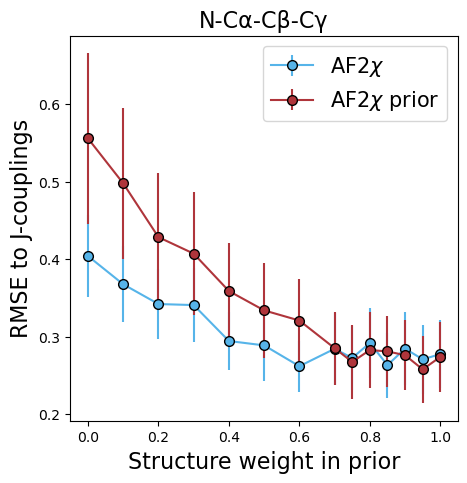

In [17]:
#Plotting for after reweweighting
fig = plt.figure(figsize=(5,5))

plt.title('N-Cα-Cβ-Cγ',fontsize=16)

plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_N_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_N_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$',markerfacecolor='#56b4e9',markeredgecolor='k',color='#56b4e9',markersize=7)
plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_N_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_N_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$ prior',markerfacecolor='#AF353B',markeredgecolor='k',color='#AF353B',markersize=7)

plt.xlabel('Structure weight in prior',fontsize=16)
plt.ylabel('RMSE to J-couplings',fontsize=16)

plt.legend(fontsize=15)

plt.savefig('../../figures/ubq_RMSEjcouplings_N_CA_CB_CG_vs_priorratio.pdf', bbox_inches='tight')
plt.savefig('../../figures/ubq_RMSEjcouplings_N_CA_CB_CG_vs_priorratio.png', bbox_inches='tight')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_211323/3402745979.py:6: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_C_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_C_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$',markerfacecolor='#56b4e9',markeredgecolor='k',color='#56b4e9',markersize=7)
/tmp/ipykernel_211323/3402745979.py:7: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_C_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_C_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$ prior',markerfacecolor='#AF353B',markeredgecolor='k',color='#AF353B',markersize=7)


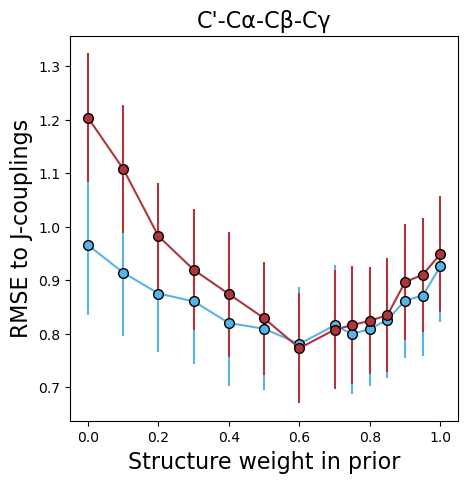

In [18]:
#Plotting for after reweweighting
fig = plt.figure(figsize=(5,5))

plt.title('C\'-Cα-Cβ-Cγ',fontsize=16)

plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_C_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_C_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$',markerfacecolor='#56b4e9',markeredgecolor='k',color='#56b4e9',markersize=7)
plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_C_CA_CB_CG'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_C_CA_CB_CG_err'], fmt='-o', label='AF2$\chi$ prior',markerfacecolor='#AF353B',markeredgecolor='k',color='#AF353B',markersize=7)

plt.xlabel('Structure weight in prior',fontsize=16)
plt.ylabel('RMSE to J-couplings',fontsize=16)

plt.savefig('../../figures/ubq_RMSEjcouplings_C_CA_CB_CG_vs_priorratio.pdf', bbox_inches='tight')
plt.savefig('../../figures/ubq_RMSEjcouplings_C_CA_CB_CG_vs_priorratio.png', bbox_inches='tight')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_211323/1368485390.py:6: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_HA_CA_CB_HB'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_HA_CA_CB_HB_err'], fmt='-o', label='AF2$\chi$',markerfacecolor='#56b4e9',markeredgecolor='k',color='#56b4e9',markersize=7)
/tmp/ipykernel_211323/1368485390.py:7: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_HA_CA_CB_HB'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_HA_CA_CB_HB_err'], fmt='-o', label='AF2$\chi$ prior',markerfacecolor='#AF353B',markeredgecolor='k',color='#AF353B',markersize=7)


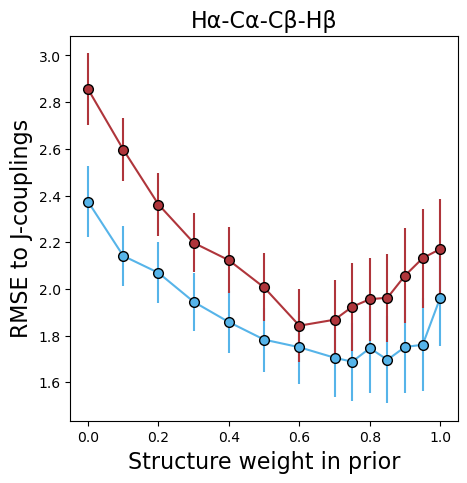

In [19]:
#Plotting for after reweweighting
fig = plt.figure(figsize=(5,5))

plt.title('Hα-Cα-Cβ-Hβ',fontsize=16)

plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_HA_CA_CB_HB'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_HA_CA_CB_HB_err'], fmt='-o', label='AF2$\chi$',markerfacecolor='#56b4e9',markeredgecolor='k',color='#56b4e9',markersize=7)
plt.errorbar(prior_ratios_floats, RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_HA_CA_CB_HB'], yerr=RMSE_vs_prior_vs_jcouplingtype['af2chi_prior_HA_CA_CB_HB_err'], fmt='-o', label='AF2$\chi$ prior',markerfacecolor='#AF353B',markeredgecolor='k',color='#AF353B',markersize=7)

plt.xlabel('Structure weight in prior',fontsize=16)
plt.ylabel('RMSE to J-couplings',fontsize=16)

plt.savefig('../../figures/ubq_RMSEjcouplings_HA_CA_CB_HB_vs_priorratio.pdf', bbox_inches='tight')
plt.savefig('../../figures/ubq_RMSEjcouplings_HA_CA_CB_HB_vs_priorratio.png', bbox_inches='tight')